## Recreating some results from Huntingford (2013), _Nature_

For the paper: _Huntingford, C., Jones, P.D., Livina, V.N., Lenton, T.M. and Cox, P.M., 2013. No increase in global temperature variability despite changing regional patterns. Nature, 500(7462), p.327._ https://www.nature.com/articles/nature12310

The original image:
<img src="files/Huntingford2013_fig1.png">




Analyis based on the median annual data (`median.nc`) dataset _Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._


))) Import required packages and set some global parameters

Some potentially useful links:

xarray plotting http://xarray.pydata.org/en/stable/plotting.html 

cartopy maps https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html



In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy.stats as st

# import iris
# import iris.plot as iplt
# import iris.quickplot as qplt




startyr = 1850
endyr = 2018
climateperiod = 11
halfperiod = int(np.floor(climateperiod/2))
numyears_data = endyr - startyr + 1

/home/ucfajsk/.conda/envs/pangeo/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


))) Load the data

In [17]:
# load the medians of the temperature anomalies from the datafile
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
dsname = 'ensemble_statistics.ann_wrt_18501900.nc' #'median.nc'
DS = xr.open_dataset(dsdir + dsname, decode_times=False)
print(DS)
t_anom_ds = DS['median']     # yearly data; [169 x 36 x 72], float32
t_anom = t_anom_ds.values
coords = t_anom_ds.coords
dims = t_anom_ds.dims

print(coords)
print(dims)

t_da = xr.DataArray(t_anom, coords, dims) 

lats = t_anom.shape[1]
lons = t_anom.shape[2]


# check for NaNs:
for yr in range(numyears_data):
    if np.isnan(np.sum(t_anom[yr,:,:])):
        print("\n Year with NaNs is :", yr+1850)
        plt.figure()
        plt.contourf(t_anom[yr])
        plt.colorbar()
        t_anom = np.delete(t_anom, yr, axis=0)
t_anom.shape

<xarray.Dataset>
Dimensions:                    (latitude: 36, longitude: 72, time: 169)
Coordinates:
  * time                       (time) int32 6 18 30 42 ... 1986 1998 2010 2022
  * latitude                   (latitude) float64 -87.5 -82.5 ... 82.5 87.5
  * longitude                  (longitude) float64 -177.5 -172.5 ... 172.5 177.5
Data variables:
    median                     (time, latitude, longitude) float32 ...
    quartile_high              (time, latitude, longitude) float32 ...
    quartile_low               (time, latitude, longitude) float32 ...
    p_le_preind                (time, latitude, longitude) float32 ...
    p_ge_plus1                 (time, latitude, longitude) float32 ...
    p_ge_plus1pt5              (time, latitude, longitude) float32 ...
    p_ge_plus1world            (time, latitude, longitude) float32 ...
    p_ge_plus1pt5world         (time, latitude, longitude) float32 ...
    p_ge_plus2world            (time, latitude, longitude) float32 ...
    p_l

(169, 36, 72)

## Figure 1a.

In [18]:
# step 1: calculate at each ECMWF grid box the yearly average temperature.
## note: already done in our dataset, hence, only calling the data is enough.
# step 2: Anomalies are then found by initially subtracting from these the average of the yearly temperatures between 1958 and 1980, 
## note: our dataset is an anomaly dataset, with respect to 1850-1900 means, rather than Huntingford's 1958-1980 means
t_anom.shape



(169, 36, 72)

In [19]:
# step 3: dividing these values by the local standard deviations of these numbers for 1958–1980. 
## we divide by the standard deviations of 1850-1900 because that is the period that the anomalies also refer to.
t_anom_divSD = np.zeros(t_anom.shape)
local_SD_18501900 = np.zeros((lats, lons))

for lat in range(lats):
    for lon in range(lons):
        local_SD_18501900[lat, lon] = np.std(t_anom[0:50, lat, lon])
            
for yr in range(numyears_data-1): # to exclude 2018 for its NaNs
    for lat in range(lats):
        for lon in range(lons):
            t_anom_divSD[yr, lat, lon] = t_anom[yr, lat, lon] / local_SD_18501900[lat, lon]
            

In [20]:
# step 4b. To allow area weighting (that is, smaller grid boxes near the poles), bin values are multiplied, 
    # for each anomaly value falling in them, by cosine (in degrees) of latitude. 
alat = np.linspace(-87.5, 87.5, 36)
def areaweight(lat):
    degree = abs(alat[lat])
    weight = np.cos(degree*np.pi/180)
    
    return weight

# step 4a. For each of the four time periods, we then put all of these normalized yearly anomalies, 
    # from across the globe, into bins of size 0.05. 
    #### 4 periods I select: 2010-2017, 2000-2009, 1980-1999, 1960-1979

# get min and max:
mini = np.min(t_anom_divSD)
maxi = np.max(t_anom_divSD)
# print(mini, maxi)

numboxlims = 201
numboxes = numboxlims - 1
boxes = np.linspace(np.floor(mini), np.ceil(maxi), numboxlims)
periods = [[2010,2017], [2000,2009], [1980,1999], [1960,1979]]
numperiods = len(periods)
datacontainer = np.zeros((numperiods, numboxes))
# print(datacontainer.shape)

i = 0
for period in periods:
    stper = period[0] - startyr
    enper = period[1] - startyr
    
    for ii in range(numboxes):
        for yr in range(stper,enper+1):
            for lat in range(lats):
                for lon in range(lons):
                    if t_anom_divSD[yr, lat, lon] > boxes[ii] and t_anom_divSD[yr, lat, lon] <= boxes[ii+1]:
                        datacontainer[i,ii] = datacontainer[i,ii] + 1*areaweight(lat)
    
    i = i + 1
    
# for x in range(4):
#     print(datacontainer[x, 95:105])
    



In [21]:
# step 5: scale area under distribution to 1/unity to allow for comparing the periods.

    # find integral
integrals = np.zeros(numperiods)
boxlength = boxes[1] - boxes[0]
print(boxlength)
for per in range(numperiods):
    for box in range(numboxes):
        integrals[per] = integrals[per] +  datacontainer[per,box] * boxlength
    
    # divide by appropriate integral and find final product
pdfs = np.zeros(datacontainer.shape)
for per in range(numperiods):
    pdfs[per,:] = datacontainer[per,:] / integrals[per]
    

0.2049999999999983


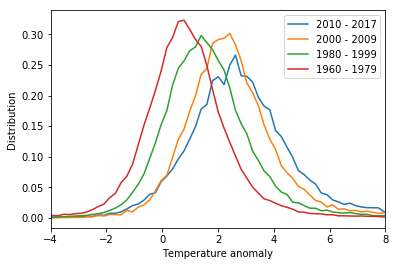

In [26]:
# And finally, plot the resulting PDFs, as in Huntingford 2013 fig 1a.
xaxesticks = np.zeros(numboxes)
for i in range(numboxes):
    xaxesticks[i] = (boxes[i] + boxes[i+1])/2

periodlabels = ["2010 - 2017", "2000 - 2009", "1980 - 1999", "1960 - 1979"]
plt.figure()
for i in range(numperiods):
    plt.plot(xaxesticks, pdfs[i,:], label=periodlabels[i])
plt.xlim((-4,8))
plt.xlabel('Temperature anomaly')
plt.ylabel('Distribution')
plt.legend()
    

## Figure 1e.

))) create running 11-yr (-5:+5) pointwise standard deviation.

In [24]:
def detrend(data):
    pwfit = np.polyfit(list(range(climateperiod)), data, 1)
    f = np.poly1d(pwfit)
    
    return data - f(list(range(climateperiod)))
            



rps_running_pointwise_SDs = np.zeros((numyears_data, lats, lons))

for yr in range(numyears_data):
    if yr <= halfperiod or yr >= (numyears_data - halfperiod):
        rps_running_pointwise_SDs[yr, :, :] = np.nan
    else:
        for lat in range(lats):
            for lon in range(lons):
                detrended_t_anom = detrend(t_anom[(yr-halfperiod):(yr+halfperiod+1), lat, lon])
                lsdvar_locationalsdofinterannvar = np.nanstd(detrended_t_anom)
                rps_running_pointwise_SDs[yr, lat, lon] = lsdvar_locationalsdofinterannvar

))) To reproduce fig 1e of Huntingford (2013):: *percentage change in periods before and after 1980*

- for plotting, probably check-out https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html

See the cmap colorschemes at: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

Text(0.5, 1.0, 'Difference pre and post in %')

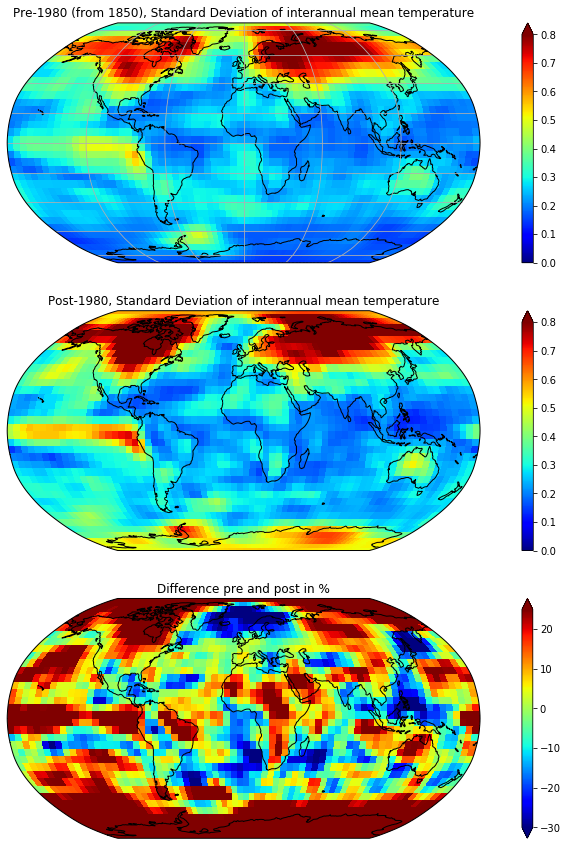

In [25]:
avsdpre_average_sd_before1980 = np.zeros((lats,lons))
avsdpost_average_sd_after1980 = np.zeros((lats,lons))
difsd_difference_sd_beforeandafter1980 = np.zeros((lats,lons))
perc_pointwise_percentagechange_sd_beforeandafter1980 = np.zeros((lats,lons))

for lat in range(lats):
    for lon in range(lons):
        avsdpre_average_sd_before1980[lat,lon] = np.nanmean(rps_running_pointwise_SDs[0:(1980-startyr), lat, lon])
        avsdpost_average_sd_after1980[lat,lon] = np.nanmean(rps_running_pointwise_SDs[(1980-startyr):numyears_data, lat, lon])
difsd_difference_sd_beforeandafter1980 = avsdpost_average_sd_after1980 - avsdpre_average_sd_before1980


perc_pointwise_percentagechange_sd_beforeandafter1980 = (difsd_difference_sd_beforeandafter1980 / avsdpre_average_sd_before1980) * 100




pre1980 = xr.DataArray(avsdpre_average_sd_before1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])
post1980 = xr.DataArray(avsdpost_average_sd_after1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])
perc_da = xr.DataArray(perc_pointwise_percentagechange_sd_beforeandafter1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])





fig = plt.figure(figsize=(15, 15))
colorscheme = 'jet'

pre = fig.add_subplot(3, 1, 1, projection=ccrs.Robinson())
pre.set_global()
pre.coastlines()
pre.gridlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
pre1980.plot(ax=pre, transform=ccrs.PlateCarree(), vmin=0, vmax=.8, cmap=colorscheme)
plt.title('Pre-1980 (from 1850), Standard Deviation of interannual mean temperature')


post = fig.add_subplot(3, 1, 2, projection=ccrs.Robinson())
post.set_global()
post.coastlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
post1980.plot(ax=post, transform=ccrs.PlateCarree(), vmin=0, vmax=.8, cmap=colorscheme)
plt.title('Post-1980, Standard Deviation of interannual mean temperature')


diff = fig.add_subplot(3, 1, 3, projection=ccrs.Robinson())
diff.set_global()
diff.coastlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
perc_da.plot(ax=diff, transform=ccrs.PlateCarree(), vmin=-30, vmax=25, cmap=colorscheme)
plt.title('Difference pre and post in %')



In [ ]:

## Unnecessary code for this script: creates a low-res 0-1 mask for land, with weighted values for coastal pixels. 


# load pagemask.nc file using xarray
dsdir = 'TemperatureVariability/'
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
np.place(mask, mask<1, 0)
np.place(mask, mask>=1, 1)
# NB.... mask.shape != grid.shape....

# for lat in mask.shape[0]:
#     for lon in mask.shape[1]:
#         continue


#np.place(mask, mask<1, np.nan)
plt.contourf(mask)

def to_lowres(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    lowresgrid = np.zeros((lats, lons))
    iratio = int(grid.shape[0]/lats) # = 10
    jratio = int(grid.shape[1]/lons) # = 10
    
    # on the t_anom grid.
    for i in range(lats): # latitude
        for j in range(lons): # longitude
            lowresgrid[i][j] = np.nanmean(grid[i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling

    return lowresgrid        
lowresworldmask = to_lowres(mask)
plt.figure()
plt.contour(lowresworldmask)
print(lowresworldmask)